In [124]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch_geometric.data import Data   


In [125]:
# global variables
dt = 0.1 # 10* dt from the computation
steps = 100

In [66]:
par_dir = './train-track-static/seed_687_1/'
dir = par_dir + 'POSTPRO/'

# Contact Force Distribution

In [67]:
prenom = 'CONTACT_FORCE_DISTRIBUTION_'
ext = '.dat'
# check the number of files starting with prenom
nb_files = len([name for name in os.listdir(dir) if name.startswith(prenom)])
dat = np.zeros((4,nb_files))
dat.shape
for i in range(1,nb_files):
    nom = prenom + str(i).zfill(7) + ext
    rf = np.loadtxt(os.path.join(dir,nom))
    dat[:,i] = rf


<Axes: title={'center': 'N_r and N_rn'}, xlabel='time'>

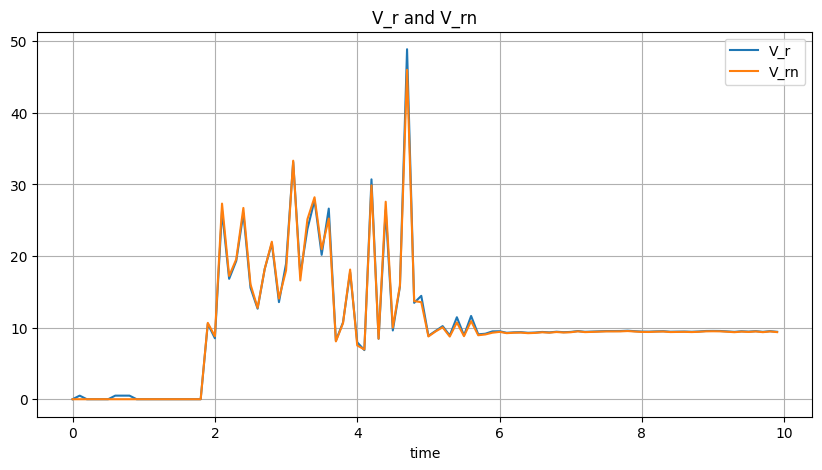

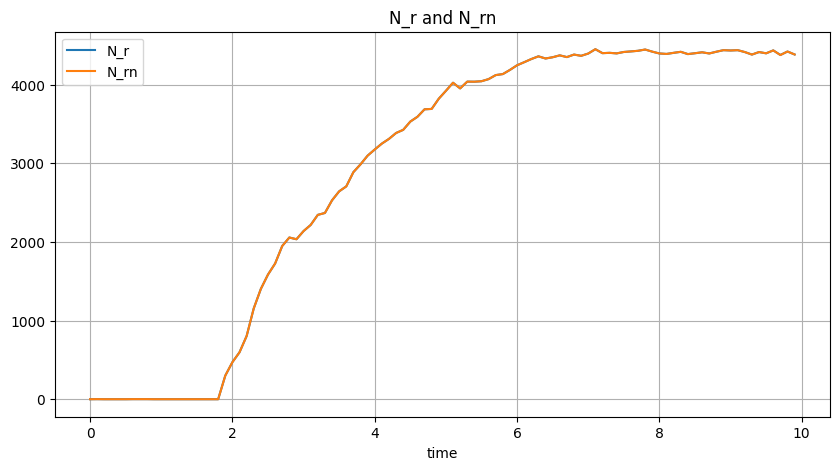

In [68]:
cfdist = pd.DataFrame(dat.T, columns=['V_r','N_r','V_rn','N_rn'])
steps_list = np.arange(0,dt*nb_files,dt)
cfdist['time'] = steps_list
# replace -inf or valus greater than 1e6 values with 0
cfdist[cfdist > 1e6] = np.inf
cfdist_fixed = cfdist.replace([np.inf, -np.inf], np.nan).fillna(0)
# replace any values greater than 1e6 with 0
cfdist_fixed.head()
cfdist_fixed.plot(x='time',y=['V_r','V_rn'],figsize=(10,5), grid=True, title='V_r and V_rn')
cfdist_fixed.plot(x='time',y=['N_r','N_rn'],figsize=(10,5), grid=True, title='N_r and N_rn')


In [69]:
cfdist.shape

(100, 5)

# Coordination Number

In [70]:
coor = np.loadtxt(dir+'COORDINATION_NUMBER.DAT')
coor_df = pd.DataFrame(coor, columns=['t', 'c_0','c_+', 'c_-', 'c'])

<Axes: title={'center': 'Coordination number'}, xlabel='t'>

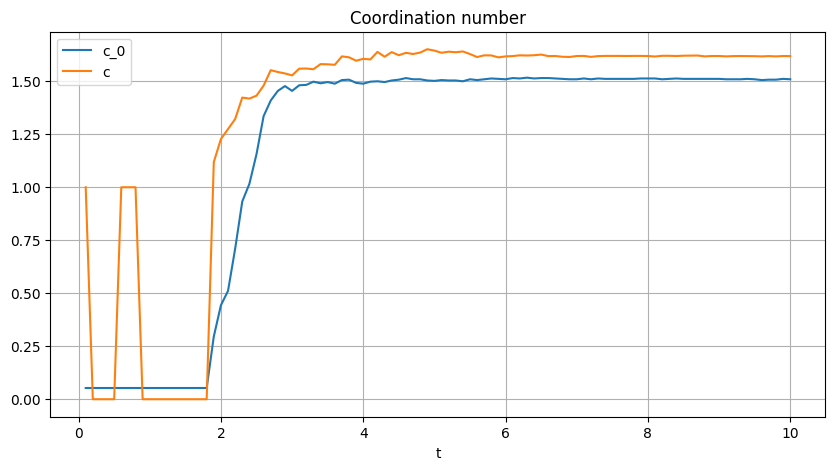

In [71]:
coor_df.plot(x='t',y=['c_0','c'],figsize=(10,5), grid=True, title='Coordination number')

In [387]:
# vectorize function
def read_bodies_vec(prenom, par_dir=par_dir, dir=dir):
    prenom = prenom
    ext = '.dat'
    nb_files = len([name for name in os.listdir(dir) if name.startswith(prenom)])
    with open(par_dir+'dict.txt') as file:
        dict = json.load(file)
    track_every = dict['Track Every']
    body_idx = np.arange(2, nb_files*track_every, track_every)
    names = [prenom + str(i).zfill(7) + ext for i in body_idx]
    bt = np.array([np.loadtxt(os.path.join(dir,name)) for name in names])
    return bt.transpose(1,2,0)

# Body Tracking

In [388]:
prenom = 'BODY_'
nb_col = 13
steps = steps
bt = read_bodies_vec(prenom)


In [389]:
df = pd.DataFrame(bt[:,:,0], columns=['t','x','y','z','dx','dy','dz','vx','vy','vz','omegax','omegay','omegaz'])


In [422]:
# create a function to plot particles movement in 3d
def plot_displacement(bt, par_dir=par_dir, n=1, filename='particle_displacement.gif'):
    [os.mkdir(os.path.join(par_dir,'plots')) if not os.path.exists(os.path.join(par_dir,'plots')) else None]
    filenames = []
    filename = par_dir+'plots/'+filename
    for t in range(len(bt)):
        figure = plt.figure()
        ax = figure.add_subplot(111, projection='3d')
        ax.scatter(bt[t,1,n], bt[t,1,n], bt[t,1,n], c='r', marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.set_title(f'Particle {n} displacement at time step {t}')
        fname = par_dir+f'plots/particle_{n}_displacement_{t}.png'
        plt.savefig(fname)
        filenames.append(fname)     
        plt.close()
    with imageio.get_writer(filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            os.remove(filename)
    print('GIF created')
    

In [424]:
n = 3
plot_displacement(bt, par_dir=par_dir, n=n, filename=f'particle_{n}_displacement.gif')


GIF created


# Torque Evolution

In [425]:
reac = read_bodies_vec('REAC_')

In [397]:
reac_df = pd.DataFrame(reac[:,:,0], columns=['t','Rx','Ry','Rz','Mx','My','Mz'])

array([ 1.0000000e+01,  1.9772375e-05, -1.3619765e-06,  3.2186242e+04,
        1.4336905e-06, -1.0110561e-06, -5.6391950e-06])

# External Forces

In [399]:
fext = read_bodies_vec('Fext_')
fext[-1,:,3]

array([ 1.0000000e+01,  0.0000000e+00,  0.0000000e+00, -5.3002235e+04,
        2.2174933e-12, -1.3822580e-12, -1.2944994e-13])

# Create Dataset

In [433]:
# Edge creation function
def create_edge_vectorized(bt,dist=100):
    diff = bt[0, 1:4, :, None] - bt[0, 1:4, None, :]
    dist_sq = np.linalg.norm(diff, axis=0)
    mask = (dist_sq < dist) & (~np.eye(bt.shape[2], dtype=bool))
    i, j = np.where(mask)
    print(f'Number of edges: {len(i)}')
    edge_index = torch.tensor([i, j])
    return edge_index

# node feature creation function
node_features = lambda bt,reac: [torch.tensor(np.concatenate((bt[step,1:7,:], reac[step, 1:7, :]))).permute(1,0) for step in range(bt.shape[0])]
node_results = lambda bt,reac: [torch.tensor(np.concatenate((bt[step,1:7,:], reac[step, 1:7, :]))).permute(1,0) for step in range(bt.shape[0])]


# one hot for ground interaction
mask_list = lambda bt: [torch.tensor(np.vstack((np.abs(bt[t, 3, :] - np.min(bt[:,3,:])) < 0.4, np.abs(bt[t, 3, :] - np.min(bt[:,3,:])) >= 0.4)).astype(int).T) for t in range(bt.shape[0])]

# force features 
force_features = lambda bt: [torch.tensor(bt[step,1:4,:]).permute(1,0) for step in range(bt.shape[0])]


In [444]:
edge_index = create_edge_vectorized(bt, dist = 10)
x = node_features(bt,reac)
n = mask_list(bt)
f = force_features(fext)


Number of edges: 282


# Create Complete Dataset for t time steps


In [445]:
save_dir = './train-track-static/pt_data/'

In [428]:
for i in range(1,50):
    par_dir = f'./train-track-static/seed_687_{i}/'
    dir = par_dir + 'POSTPRO/'
    bt = read_bodies_vec('BODY_')
    reac = read_bodies_vec('REAC_')
    fext = read_bodies_vec('Fext_')
    x = node_features(bt[:-1],reac[:-1])
    f = force_features(fext[:-1])
    n = mask_list(bt[:-1])
    edge_index = create_edge_vectorized(bt, dist = 10)
    edge_index = [edge_index for _ in range(bt.shape[0]-1)]
    y = node_results(bt[1:],reac[1:])
    data_list = [Data(x=x[i], f=f[i], n=n[i], edge_index=edge_index[i], y=y[i]) for i in range(len(x))]
    torch.save(data_list, save_dir +f_'freefall_{i}.pt')
    print(f'File {i} saved')



Number of edges: 282
torch.float64 torch.float64 torch.int64 torch.int64 torch.float64
